# Text-Based Firm Similarity Based on Edgar 10-K Report

In [1]:
import pandas as pd

## visualization of intermediate process

First the raw data is formatted by tags, like `HTML`, so in the raw text the string is not only the content but tags like `<something></something>`. We need to filter out these things.

In [4]:
with open('aapl_raw.txt') as f:
    print(f.read()[:500])

<SEC-DOCUMENT>0000320193-20-000096.txt : 20201030
<SEC-HEADER>0000320193-20-000096.hdr.sgml : 20201030
<ACCEPTANCE-DATETIME>20201029180625
ACCESSION NUMBER:		0000320193-20-000096
CONFORMED SUBMISSION TYPE:	10-K
PUBLIC DOCUMENT COUNT:		99
CONFORMED PERIOD OF REPORT:	20200926
FILED AS OF DATE:		20201030
DATE AS OF CHANGE:		20201029

FILER:

	COMPANY DATA:	
		COMPANY CONFORMED NAME:			Apple Inc.
		CENTRAL INDEX KEY:			0000320193
		STANDARD INDUSTRIAL CLASSIFICATION:	ELECTRONIC COMPUTERS [3571]
		IR


After the filtering (**parse**) process, we can get the "pure" string of content, especially the business sector content, which is really what we need. Also, we want to abondon the financial statements data (only number, not contributed much to our analysis).

In [5]:
with open('aapl.txt') as f:
    print(f.read()[:500])

The following discussion of risk factors contains forward-looking statements. These risk factors may be important to understanding other statements in this Form 10-K. The following information should be read in conjunction with Part II, Item 7, “Management’s Discussion and Analysis of Financial Condition and Results of Operations” and the consolidated financial statements and accompanying notes in Part II, Item 8, “Financial Statements and Supplementary Data” of this Form 10-K.

The business, fi


In [6]:
doc = pd.read_feather('doc.feather')[['document', 'tic']]

let's see the example of *Apple*. ( divided words )

In [7]:
aapl_word = doc.loc[doc.tic == 'AAPL'].document.values.tolist()[0]
len(aapl_word)

3155

In [8]:
' '.join(aapl_word)[:500]

'Item Risk Factors discussion risk factors statements risk factors statements K information conjunction Part II Item Management Discussion Analysis Financial Condition Results Operations statements notes Part II Item Financial Statements Supplementary Data Form K business condition results Company number factors Company condition results future condition results factors part Company business condition results stock price factors factors Company condition results performance indicator performance '

In [9]:
doc

,document,tic
0,"[Item, Risk, Factors, Risks, Factors, Company,...",A
1,"[Item, Risk, Factors, Alcoa, business, conditi...",AA
2,"[Item, Ris, k, Factors, risk, factors, informa...",AADI
3,"[ITEM, RI, SK, FACTORS, Investing, company, ri...",AAIC
4,"[ITEM, RI, SK, FACTORS, Investing, company, ri...",AAIN
...,...,...
1816,"[Item, Risk, Factors, risks, report, ones, bus...",LBRDK
1817,"[Item, Risk, Factors, risks, report, ones, bus...",LBRDP
1818,"[Item, Risk, Factors, risks, apply, business, ...",LBRT
1819,"[Item, Risk, Factors, discussion, sets, risk, ...",LEU


## remove common words (test)

We just try this step, but it is not easy to figure out the definition of **common words**. 

- the number of apperance in one documnet is counted as one time (`count_words`)

- or the total number of the words (`all_words`)

The following just to show the idea.

In [23]:
all_words = []
count_words = []

for document in doc['document']:
    count_list = []
    for word in document:
        all_words.append(word)
        count_list.append(word)
    count_words += list(set(count_list))

In [24]:
len(all_words), len(count_words)

(6590504, 1454486)

In [29]:
from collections import Counter

counter = Counter(all_words)
print(len(counter), '\n\n')
print(counter.most_common(10), '\n\n')
print(pd.Series(counter).describe(), '\n\n')

39334 


[('business', 121029), ('operations', 71860), ('products', 67217), ('product', 63866), ('results', 61296), ('ability', 55168), ('stock', 49160), ('market', 47110), ('laws', 36587), ('addition', 36046)] 


count     39334.000000
mean        167.552347
std        1568.907172
min           1.000000
25%           1.000000
50%           3.000000
75%          16.000000
max      121029.000000
dtype: float64 




In [30]:
counter = Counter(count_words)
print(len(counter), '\n\n')
print(counter.most_common(10), '\n\n')
print(pd.Series(counter).describe(), '\n\n')

39334 


[('information', 1429), ('operations', 1426), ('business', 1425), ('results', 1425), ('ability', 1423), ('effect', 1419), ('addition', 1418), ('changes', 1418), ('Item', 1418), ('risks', 1417)] 


count    39334.000000
mean        36.977831
std        144.828437
min          1.000000
25%          1.000000
50%          2.000000
75%          7.000000
max       1429.000000
dtype: float64 




Anyway, we want to eventually achieve a distribution like this.

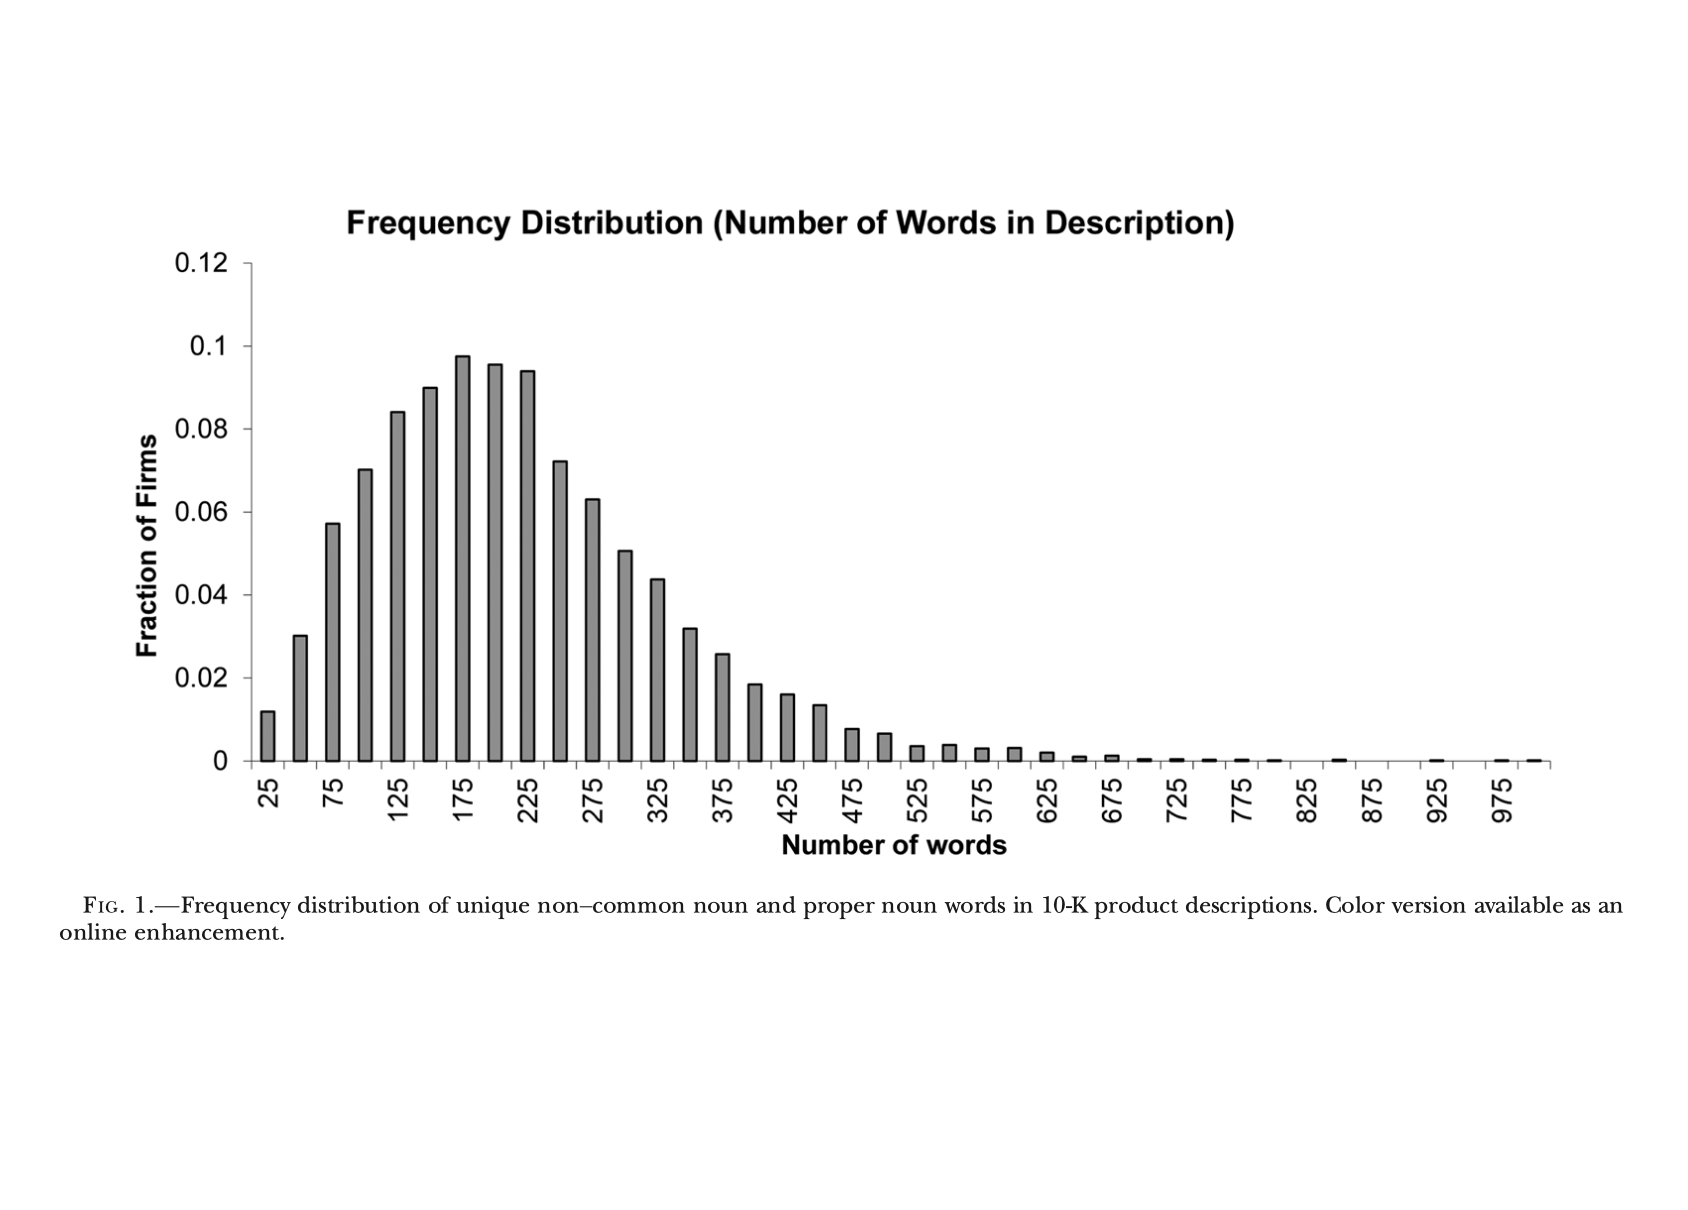

In [31]:
from IPython.display import Image
Image(filename='distribution.png') 

## doc2vec

In [14]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [15]:
len(doc['document'].values)

1821

tag the words

In [16]:
tagged_list = []

for i, text in enumerate(doc['document'].values):
    tagged = TaggedDocument(text, tags=[i])
    tagged_list.append(tagged)

train the model

In [17]:
model = Doc2Vec(tagged_list)

In [18]:
model.train(tagged_list, total_examples = model.corpus_count, epochs = 10)

## perceptual verification

In [101]:
aapl_word = doc.loc[doc.tic == 'AAPL'].document.values.tolist()[0]
fb_word = doc.loc[doc.tic == 'FB'].document.values.tolist()[0]

In [102]:
aapl_vec = model.infer_vector(aapl_word)
fb_vec = model.infer_vector(fb_word)

In [103]:
aapl_vec

array([ 0.9080916 , -0.8299222 ,  1.376746  ,  3.0427096 ,  0.11979463,
       -0.6863002 , -0.47481593,  0.33787745, -3.002526  , -1.566104  ,
       -0.90923285,  1.5709052 , -1.4958167 , -2.062923  , -1.5557505 ,
        0.798923  ,  0.71638983, -1.9710233 ,  0.83104384,  0.93284655,
       -1.5399776 ,  0.08883175, -0.7368261 ,  0.80477476, -1.0823696 ,
       -1.6748545 , -1.7702042 ,  0.92265826,  1.6042262 , -1.9875891 ,
       -0.4602296 , -1.5258312 , -1.4144254 , -1.8153275 , -1.1877234 ,
       -1.8451042 ,  0.7513867 , -3.0829766 ,  1.8986567 , -0.86224854,
       -0.84612453,  0.4431758 ,  3.4588318 ,  1.0194103 ,  0.7060127 ,
        0.9791193 ,  0.22570309, -0.7940582 , -0.36241856,  0.50655955,
        0.4882526 , -3.2900677 , -0.20828186,  0.38481295, -1.3440944 ,
        0.9886637 , -1.6252785 ,  1.4794798 ,  0.26175046,  0.87602997,
        2.354815  ,  1.8029058 ,  3.1995082 , -0.9646226 ,  0.27929136,
       -0.2826818 , -1.4399389 ,  0.19343975, -0.6681565 ,  1.07

In [105]:
aapl_most_similar = model.docvecs.most_similar(aapl_vec, topn = 10)
fb_most_similar = model.docvecs.most_similar(fb_vec, topn = 10)
aapl_most_similar

<ipython-input-105-5c56a95074f0>:1: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  aapl_most_similar = model.docvecs.most_similar(aapl_vec, topn = 10)
<ipython-input-105-5c56a95074f0>:2: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  fb_most_similar = model.docvecs.most_similar(fb_vec, topn = 10)


[(11, 0.9756932258605957),
 (53, 0.7075507640838623),
 (1236, 0.6876292824745178),
 (1399, 0.6802329421043396),
 (1163, 0.6642958521842957),
 (408, 0.6569865345954895),
 (370, 0.6532212495803833),
 (245, 0.6501213312149048),
 (1612, 0.6480929851531982),
 (1278, 0.6179130673408508)]

In [107]:
doc.iloc[[i[0] for i in aapl_most_similar], :]

,document,tic
11,"[Item, Risk, Factors, discussion, risk, factor...",AAPL
53,"[Item, Risk, Factors, Company, number, risks, ...",ACU
1236,"[ITEM, RISK, FACTORS, describes, risks, Compan...",FELE
1399,"[ITEM, RISK, FACTORS, risks, cases, Company, r...",GPK
1163,"[ITEM, RISK, FACTORS, Operating, results, chan...",ESCA
408,"[ITEM, RISK, FACTORS, Investors, Company, secu...",BB
370,"[Item, Risk, Factors, Forward, Statements, Ris...",AVT
245,"[Item, Risk, Factors, Investors, risks, inform...",APH
1612,"[Item, Risk, Factors, Company, DTX, AMS, techn...",IKNX
1278,"[Item, Risk, Factors, Statements, Private, Sec...",FLWS


- **ACU: Acme United Corporation**

Acme United Corporation is a supplier of cutting, measuring and safety products for the school, home, office, hardware and industrial markets.

- **FELE: Franklin Electric**

Franklin Electric is a manufacturer and distributor of products and systems focused on the movement and management of water and fuel. 

- **GPK: Graphic Packaging Holding Company**

Graphic Packaging Holding Company operates as an integrated provider of paperboard and integrated paperboard packaging solutions to multinational beverage and consumer products companies. The Company manufactures folding cartons for frozen and non-frozen food and beverage products.

- ...

In [106]:
doc.iloc[[i[0] for i in fb_most_similar], :]

,document,tic
1232,"[Item, Risk, Factors, Certain, factors, effect...",FB
966,"[ITEM, RISK, FACTORS, Investing, Class, A, sto...",DBX
1075,"[Item, Risk, Factors, A, description, risks, u...",EB
1187,"[Item, Risk, Factors, securities, degree, risk...",ETSY
1403,"[Item, Risk, Factors, risks, information, Annu...",GPRO
1272,"[Item, Risk, Factors, business, condition, res...",FLNT
393,"[Item, Risk, Factors, investment, Class, A, st...",AYX
700,"[Item, Risk, Factors, Item, Unresolved, Staff,...",CHGG
1692,"[ITEM, RISK, FACTORS, addition, information, r...",IZEA
1024,"[Item, Risk, Factors, risk, factors, addition,...",DOMO


- **DBX: Dropbox Inc.**

Dropbox is a file hosting service operated by the American company Dropbox, Inc., headquartered in San Francisco, California, US that offers cloud storage, file synchronization, personal cloud, and client software.

- **EB: Eventbrite Inc.**

Eventbrite is an American event management and ticketing website. The service allows users to browse, create, and promote local events. The service charges a fee to event organizers in exchange for online ticketing services, unless the event is free.
- **EB: Etsy Inc.**

Etsy, Inc. is an American e-commerce company focused on handmade or vintage items and craft supplies.
- ...

In [108]:
# FB: Meta Platforms Inc.